In [9]:
import sys 
sys.path.append('../../')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Grayscale
from torchvision.datasets import MNIST, CIFAR10 
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

%autoreload 2
from networks import *
from utils import *
from losses import *
from landscape import *
from datasets import *
from train_utils import *

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Training Setup

In [15]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=100
dims_latent = 32                            
learning_rate=1e-3
batch_size=128                                        
device=set_device("cuda", 0)
train_size=0.8

# Losses
l2loss    = nn.MSELoss(reduction="sum")
awi1D     = AWLoss(filter_dim=1, method="fft", reduction="sum", std=3e-4, store_filters="norm", epsilon=3e-15)
awi2D     = AWLoss(filter_dim=2, method="fft", reduction="sum", std=3e-4, store_filters="norm", epsilon=3e-7)
awi3D     = AWLoss(filter_dim=3, method="fft", reduction="sum", std=3e-4, store_filters="norm", epsilon=3e-7, filter_scale=3)


Cuda installed! Running on GPU 0 NVIDIA A100-SXM4-80GB!


## Datasets and Dataloaders

In [16]:
# Datasets and dataloaders
train_transform = Compose([
    Resize(28),
    ToTensor(),
])

ds = MNIST("../data", download=True, train=True, transform=train_transform)
try:
    shuffler = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=42).split(ds.data, ds.targets)
    train_idx, valid_idx = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]
except:
    train_idx=[7]

X_train, y_train = ds.data[train_idx] / 255., ds.targets[train_idx]
trainds = TensorDataset(X_train.unsqueeze(1).float(), y_train.float())

train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)

X = trainds[0][0].unsqueeze(0).to(device) # a sample for check ups
print("Trainable Images:", len(trainds))
print(X.shape, X.min().item(), X.max().item())


Trainable Images: 48000
torch.Size([1, 1, 28, 28]) 0.0 1.0


## Autoencoder (CNN)

In [17]:
def model_instance():
    return nn.DataParallel(CAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device))

model_sample = model_instance()

print(model_sample)
print(X.shape, model_sample(X).shape)

DataParallel(
  (module): CAE28(
    (activation): Mish()
    (sigmoid): Sigmoid()
    (sine): Sine()
    (e_cv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2))
    (e_cv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (e_cv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (e_fc5): Linear(in_features=128, out_features=32, bias=True)
    (d_fc1): Linear(in_features=32, out_features=128, bias=True)
    (d_cv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(3, 3))
    (d_cv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(3, 3))
    (d_cv4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(3, 3))
  )
)
torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


## Training MSE Loss



Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'loss': 6381.193359375, 'mse (validation)': 0.037481386214494705, 'kl_loss': 0.0}


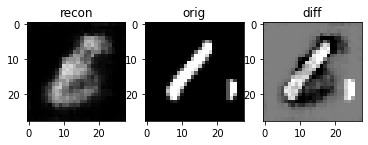

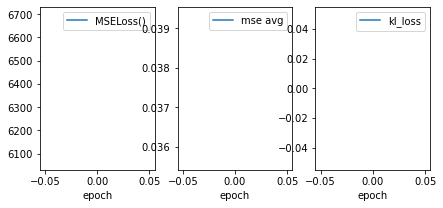

 20% (20 of 100) |####                   | Elapsed Time: 0:10:20 ETA:   0:42:09


 {'epoch': 20, 'loss': 777.9524536132812, 'mse (validation)': 0.007620450109243393, 'kl_loss': 0.0}


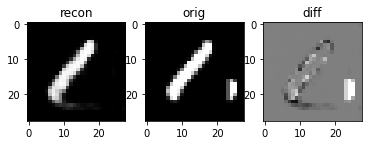

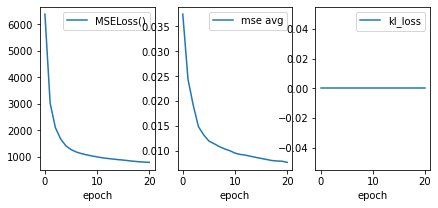

 40% (40 of 100) |#########              | Elapsed Time: 0:20:46 ETA:   0:31:02


 {'epoch': 40, 'loss': 638.8497314453125, 'mse (validation)': 0.006290067918598652, 'kl_loss': 0.0}


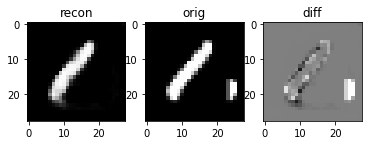

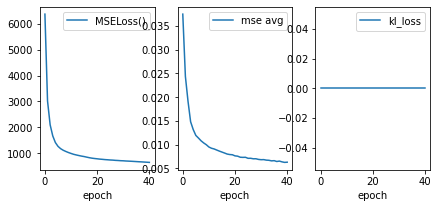

 41% (41 of 100) |#########              | Elapsed Time: 0:21:18 ETA:   0:30:57Exception ignored in: <function _releaseLock at 0x7fdb4f1c0700>
Traceback (most recent call last):
  File "/home/dp4018/miniconda3/envs/mltorch/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
 60% (60 of 100) |#############          | Elapsed Time: 0:31:20 ETA:   0:19:24


 {'epoch': 60, 'loss': 556.4492797851562, 'mse (validation)': 0.0055048903450369835, 'kl_loss': 0.0}


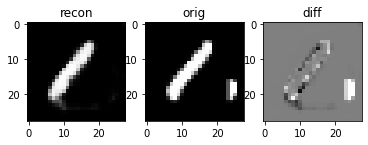

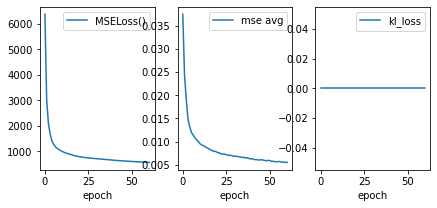

 80% (80 of 100) |##################     | Elapsed Time: 0:41:00 ETA:   0:09:37


 {'epoch': 80, 'loss': 510.68072509765625, 'mse (validation)': 0.004976758733391762, 'kl_loss': 0.0}


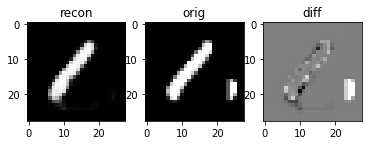

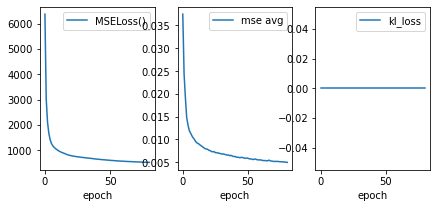

 99% (99 of 100) |###################### | Elapsed Time: 0:50:09 ETA:   0:00:29


 {'epoch': 99, 'loss': 480.0819091796875, 'mse (validation)': 0.004651379305869341, 'kl_loss': 0.0}


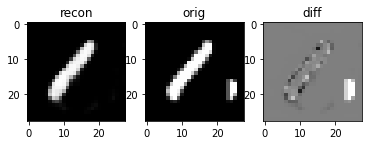

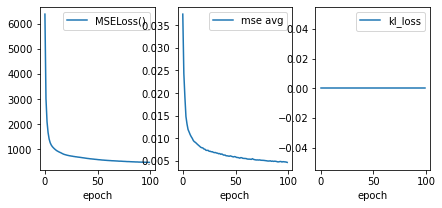

100% (100 of 100) |######################| Elapsed Time: 0:50:09 Time:  0:50:09


In [18]:
model = model_instance()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, optimizer, train_loader, l2loss, nepochs, log_frequency=20, sample=X, device=device, gradflow=False)

### Loss Landscape

In [11]:
# train_subset = Subset(trainds, list(np.random.randint(0, len(trainds), size=16)))
# train_subloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
# print("Train Subset len: ", len(train_subset))
# xx, yy, loss_landscape = visualise_landscape(model, train_subloader, awi1D, device=device)

## Training AWLoss1D



Training started ...


/home/dp4018/miniconda3/envs/mltorch/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180487213/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[W Copy.cpp:244] Warning: Casting complex values to real discards the imaginary part (function operator())
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'loss': 89.22280883789062, 'mse (validation)': 0.15981720387935638, 'kl_loss': 0.0}
 argidx T, v:  783 842


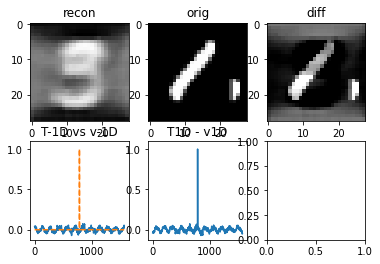

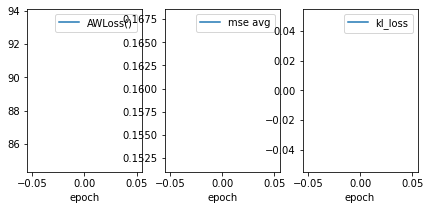

 20% (20 of 100) |####                   | Elapsed Time: 0:16:49 ETA:   1:08:39


 {'epoch': 20, 'loss': 70.48786926269531, 'mse (validation)': 0.016515618190169334, 'kl_loss': 0.0}
 argidx T, v:  783 783


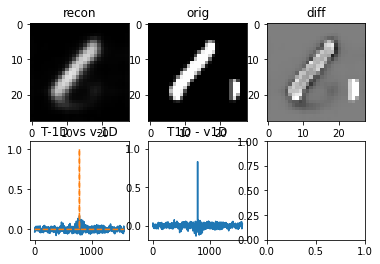

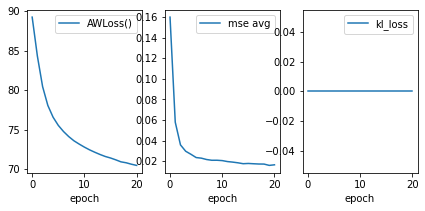

 40% (40 of 100) |#########              | Elapsed Time: 0:33:41 ETA:   0:49:18


 {'epoch': 40, 'loss': 68.4119644165039, 'mse (validation)': 0.014114403165876865, 'kl_loss': 0.0}
 argidx T, v:  783 783


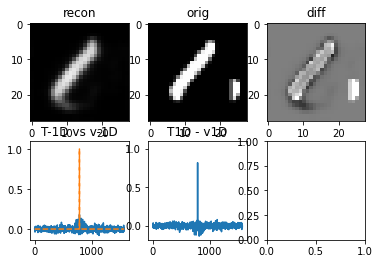

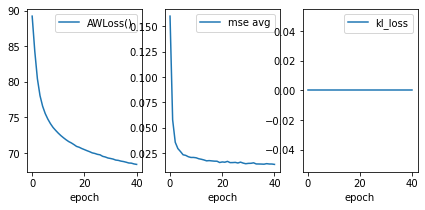

 60% (60 of 100) |#############          | Elapsed Time: 0:50:21 ETA:   0:32:36


 {'epoch': 60, 'loss': 67.2953872680664, 'mse (validation)': 0.013175270520150661, 'kl_loss': 0.0}
 argidx T, v:  783 783


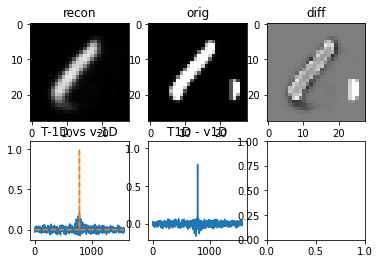

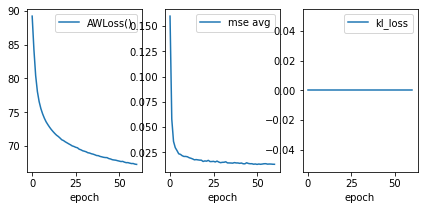

 80% (80 of 100) |##################     | Elapsed Time: 1:07:04 ETA:   0:16:44


 {'epoch': 80, 'loss': 66.55175018310547, 'mse (validation)': 0.012896226719021797, 'kl_loss': 0.0}
 argidx T, v:  783 783


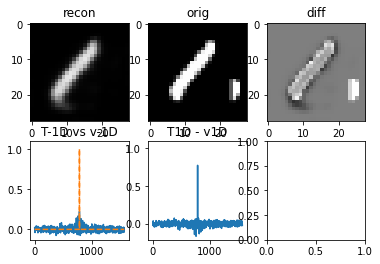

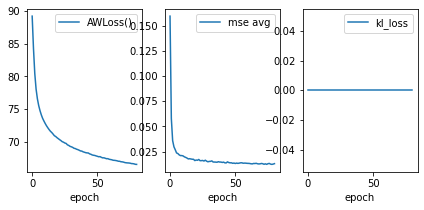

 99% (99 of 100) |###################### | Elapsed Time: 1:22:50 ETA:   0:00:48


 {'epoch': 99, 'loss': 65.98658752441406, 'mse (validation)': 0.0120630394667387, 'kl_loss': 0.0}
 argidx T, v:  783 783


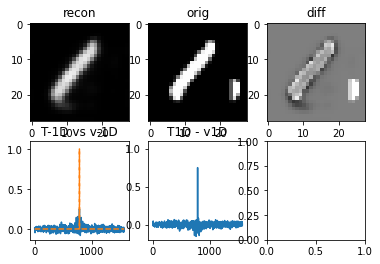

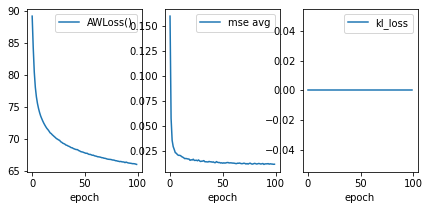

100% (100 of 100) |######################| Elapsed Time: 1:22:50 Time:  1:22:50


In [19]:
model = model_instance()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, optimizer, train_loader, awi1D, nepochs, log_frequency=20, sample=X, device=device, gradflow=False)

### Loss Landscape

In [16]:
# train_subset = Subset(trainds, list(np.random.randint(0, len(trainds), size=16)))
# train_subloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
# print("Train Subset len: ", len(train_subset))
# xx, yy, loss_landscape = visualise_landscape(model, train_subloader, awi1D, device=device)

## Training AWLoss2D



Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'loss': 0.714195191860199, 'mse (validation)': 0.2256554812192917, 'kl_loss': 0.0}
 argidx T, v:  1512 2480


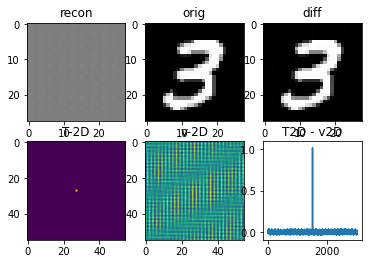

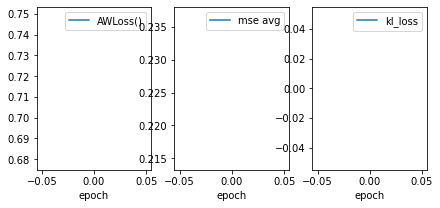

  1% (1 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:01:17
  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:51
  3% (3 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:41
  4% (4 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:36
  5% (5 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:33
  6% (6 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:31
  7% (7 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:30
  8% (8 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:29
  9% (9 of 100) |##                      | Elapsed Time: 0:00:02 ETA:   0:00:28
 10% (10 of 100) |##                     | Elapsed Time: 0:00:03 ETA:   0:00:22
 11% (11 of 100) |##                     | Elapsed Time: 0:00:03 ETA:   0:00:21
 12% (12 of 100) |##                     | Elapsed Time: 0:00:03 ETA:   0:00:21
 13% (13 of 100) |##                    


 {'epoch': 20, 'loss': 0.6139521598815918, 'mse (validation)': 0.25625988841056824, 'kl_loss': 0.0}
 argidx T, v:  1512 1512


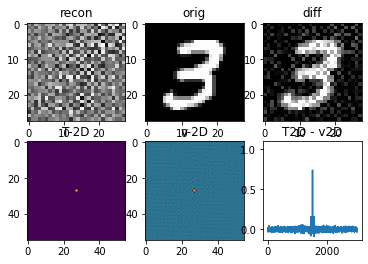

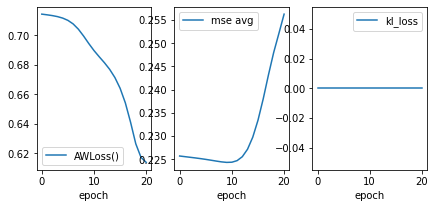

 21% (21 of 100) |####                   | Elapsed Time: 0:00:06 ETA:   0:00:26
 22% (22 of 100) |#####                  | Elapsed Time: 0:00:06 ETA:   0:00:26
 23% (23 of 100) |#####                  | Elapsed Time: 0:00:06 ETA:   0:00:26
 24% (24 of 100) |#####                  | Elapsed Time: 0:00:07 ETA:   0:00:26
 25% (25 of 100) |#####                  | Elapsed Time: 0:00:07 ETA:   0:00:26
 26% (26 of 100) |#####                  | Elapsed Time: 0:00:07 ETA:   0:00:26
 27% (27 of 100) |######                 | Elapsed Time: 0:00:07 ETA:   0:00:24
 28% (28 of 100) |######                 | Elapsed Time: 0:00:08 ETA:   0:00:23
 29% (29 of 100) |######                 | Elapsed Time: 0:00:08 ETA:   0:00:22
 30% (30 of 100) |######                 | Elapsed Time: 0:00:08 ETA:   0:00:17
 31% (31 of 100) |#######                | Elapsed Time: 0:00:08 ETA:   0:00:16
 32% (32 of 100) |#######                | Elapsed Time: 0:00:08 ETA:   0:00:16
 33% (33 of 100) |#######               


 {'epoch': 40, 'loss': 0.4774703085422516, 'mse (validation)': 0.24604566395282745, 'kl_loss': 0.0}
 argidx T, v:  1512 1512


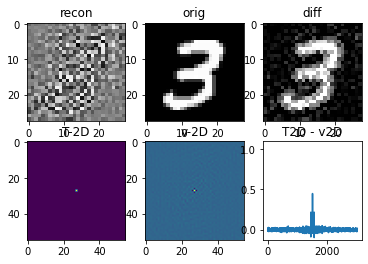

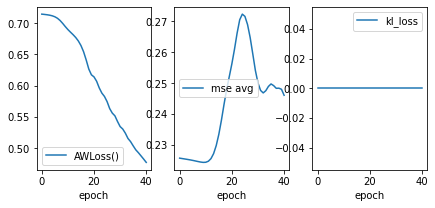

 41% (41 of 100) |#########              | Elapsed Time: 0:00:11 ETA:   0:00:20
 42% (42 of 100) |#########              | Elapsed Time: 0:00:12 ETA:   0:00:20
 43% (43 of 100) |#########              | Elapsed Time: 0:00:12 ETA:   0:00:19
 44% (44 of 100) |##########             | Elapsed Time: 0:00:12 ETA:   0:00:18
 45% (45 of 100) |##########             | Elapsed Time: 0:00:12 ETA:   0:00:18
 46% (46 of 100) |##########             | Elapsed Time: 0:00:13 ETA:   0:00:18
 47% (47 of 100) |##########             | Elapsed Time: 0:00:13 ETA:   0:00:17
 48% (48 of 100) |###########            | Elapsed Time: 0:00:13 ETA:   0:00:16
 49% (49 of 100) |###########            | Elapsed Time: 0:00:13 ETA:   0:00:15
 50% (50 of 100) |###########            | Elapsed Time: 0:00:14 ETA:   0:00:12
 51% (51 of 100) |###########            | Elapsed Time: 0:00:14 ETA:   0:00:12
 52% (52 of 100) |###########            | Elapsed Time: 0:00:14 ETA:   0:00:11
 53% (53 of 100) |############          


 {'epoch': 60, 'loss': 0.3978581726551056, 'mse (validation)': 0.24061278998851776, 'kl_loss': 0.0}
 argidx T, v:  1512 1512


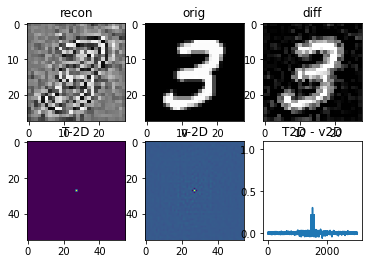

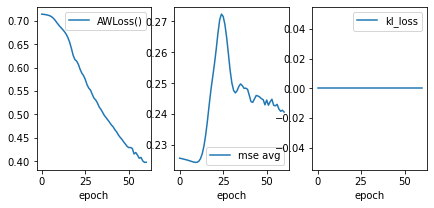

 61% (61 of 100) |##############         | Elapsed Time: 0:00:17 ETA:   0:00:12
 62% (62 of 100) |##############         | Elapsed Time: 0:00:17 ETA:   0:00:12
 63% (63 of 100) |##############         | Elapsed Time: 0:00:17 ETA:   0:00:11
 64% (64 of 100) |##############         | Elapsed Time: 0:00:17 ETA:   0:00:11
 65% (65 of 100) |##############         | Elapsed Time: 0:00:18 ETA:   0:00:11
 66% (66 of 100) |###############        | Elapsed Time: 0:00:18 ETA:   0:00:10
 67% (67 of 100) |###############        | Elapsed Time: 0:00:18 ETA:   0:00:10
 68% (68 of 100) |###############        | Elapsed Time: 0:00:18 ETA:   0:00:09
 69% (69 of 100) |###############        | Elapsed Time: 0:00:19 ETA:   0:00:09
 70% (70 of 100) |################       | Elapsed Time: 0:00:19 ETA:   0:00:07
 71% (71 of 100) |################       | Elapsed Time: 0:00:19 ETA:   0:00:07
 72% (72 of 100) |################       | Elapsed Time: 0:00:19 ETA:   0:00:07
 73% (73 of 100) |################      


 {'epoch': 80, 'loss': 0.34701406955718994, 'mse (validation)': 0.23610615730285645, 'kl_loss': 0.0}
 argidx T, v:  1512 1512


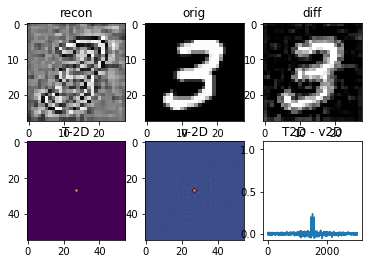

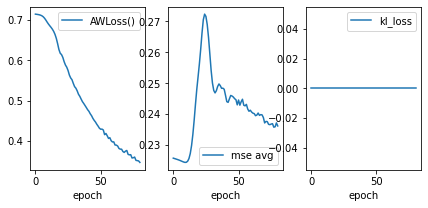

 81% (81 of 100) |##################     | Elapsed Time: 0:00:22 ETA:   0:00:06
 82% (82 of 100) |##################     | Elapsed Time: 0:00:23 ETA:   0:00:06
 83% (83 of 100) |###################    | Elapsed Time: 0:00:23 ETA:   0:00:05
 84% (84 of 100) |###################    | Elapsed Time: 0:00:23 ETA:   0:00:05
 85% (85 of 100) |###################    | Elapsed Time: 0:00:23 ETA:   0:00:05
 86% (86 of 100) |###################    | Elapsed Time: 0:00:24 ETA:   0:00:04
 87% (87 of 100) |####################   | Elapsed Time: 0:00:24 ETA:   0:00:04
 88% (88 of 100) |####################   | Elapsed Time: 0:00:24 ETA:   0:00:03
 89% (89 of 100) |####################   | Elapsed Time: 0:00:24 ETA:   0:00:03
 90% (90 of 100) |####################   | Elapsed Time: 0:00:24 ETA:   0:00:02
 91% (91 of 100) |####################   | Elapsed Time: 0:00:25 ETA:   0:00:02
 92% (92 of 100) |#####################  | Elapsed Time: 0:00:25 ETA:   0:00:01
 93% (93 of 100) |##################### 


 {'epoch': 99, 'loss': 0.32318857312202454, 'mse (validation)': 0.2313181757926941, 'kl_loss': 0.0}
 argidx T, v:  1512 1512


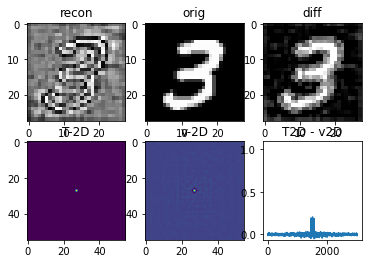

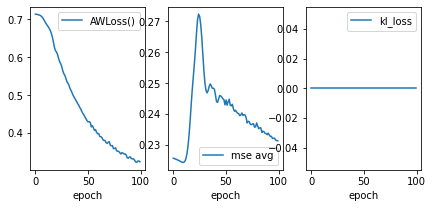

100% (100 of 100) |######################| Elapsed Time: 0:00:27 Time:  0:00:27


In [9]:
model = model_instance()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, optimizer, train_loader, awi2D, nepochs, log_frequency=20, sample=X, device=device, gradflow=False)

### Loss Landscape

In [18]:
# train_subset = Subset(trainds, list(np.random.randint(0, len(trainds), size=16)))
# train_subloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
# print("Train Subset len: ", len(train_subset))
# xx, yy, loss_landscape = visualise_landscape(model, train_subloader, awi2D, device=device)